# import modules

In [28]:
import sys

sys.path.insert(0, "../")

from modules.Classes_ver1 import *
from modules.default_params_ver1 import *
from modules.functions_ver1_draft import *

plt.rcParams["figure.dpi"] = 150

# assign params

In [29]:
lens_params, RP_params, NP_params = set_to_params(lens_params_1, RP_params_1, NP_params_1)

# define functions

In [30]:
def omit_numerical_errors(arr, n=16, order=1.5) -> np.ndarray:
    """
    Omit numerical errors in an array by replacing values that are greater than a certain order of the median with NaN.

    Parameters:
    - arr (array-like): The input array.
    - n (int): The number of neighbors to consider when calculating the median. Default is 16.
    - order (float): The order of the median used to determine if a value is an error. Default is 1.5.

    Returns:
    - np.ndarray: The modified array with numerical errors omitted.
    """

    assert len(arr) >= n, "Array length must be greater than or equal to n."
    arr_copy = np.array(arr.copy())

    for i in range(len(arr_copy)):
        if i < n // 2:
            neighbors = arr_copy[:n]
        elif i >= len(arr_copy) - n // 2:
            neighbors = arr_copy[-n:]
        else:
            neighbors = arr_copy[i - n // 2 : i + n // 2]

        median = np.nanmedian(neighbors)
        if arr_copy[i] > order * median:
            arr_copy[i] = np.nan

    return arr_copy

In [31]:
mcz_L_arr = np.linspace(70, 90, 200)

def mismatch_plot_general_zoomed(opt_match=True):
    optimized_mcz_dict = {}
    ep_NP_L_arr = np.zeros(len(mcz_L_arr))
    optimized_ep_NP_L_arr = np.zeros(len(mcz_L_arr))
    optimized_ep_NP_L_mcz = np.zeros(len(mcz_L_arr))

    lens_inst = LensingGeo(lens_params)
    Delta_td = lens_inst.Delta_td()
    I = lens_inst.I()

    for i, mcz_L in enumerate(mcz_L_arr):
        lens_params["mcz"] = RP_params["mcz"] = NP_params["mcz"] = mcz_L * solar_mass

        ep_NP_L = mismatch_general(
            NP_params, lens_params, use_optimized_match=opt_match
        )["mismatch"]
        
        ep_NP_L_arr[i] = ep_NP_L

        optimized_ep_NP_L_dict = optimize_mismatch_mcz_general(
            NP_params, lens_params, use_optimized_match=opt_match
        )
        optimized_ep_NP_L_arr[i] = optimized_ep_NP_L_dict["ep_min"]
        optimized_ep_NP_L_mcz[i] = optimized_ep_NP_L_dict["ep_min_mcz"]

    ep_NP_L_arr = omit_numerical_errors(ep_NP_L_arr)
    optimized_mcz_dict = {
        "mcz_L_arr": mcz_L_arr,
        "ep_NP_L_arr": ep_NP_L_arr,
        "optimized_ep_NP_L_arr": optimized_ep_NP_L_arr,
        "optimized_ep_NP_L_mcz": optimized_ep_NP_L_mcz,
    }

    # plot mismatch vs mcz
    plt.plot(mcz_L_arr, optimized_mcz_dict["ep_NP_L_arr"], label=r"$\epsilon$", ls="-")

    plt.xlabel(r"$\mathcal{M}_{\text{s}}$ $[M_{\odot}]$")
    plt.ylabel(r"$\epsilon(\~h_{\rm NP}, \~h_{\rm L})$")
    plt.legend()
    plt.title(
        r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, $\Delta t_d$ = {:.3g} s, $I$ = {:.3g}".format(
            lens_params["theta_S"],
            lens_params["phi_S"],
            lens_params["theta_J"],
            lens_params["phi_J"],
            Delta_td,
            I,
        )
    )

    plt.suptitle(r"Actual Mismatch Between NP Templates & a Lensed Source")

    return optimized_mcz_dict

# mismatch optimized over $\tilde{\theta}$, $\tilde{\Omega}$, and $\gamma_P$

In [21]:
from multiprocessing import Pool

def compute_mismatch(r, c, t_params, s_params, lens_Class, prec_Class, opt_match):
    n_pts = 20
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    t_params["omega_tilde"] = X[r, c]
    t_params["theta_tilde"] = Y[r, c]

    optimized_mismatch_results_dict = optimize_mismatch_gammaP_general(t_params, s_params, lens_Class, prec_Class, opt_match)

    return optimized_mismatch_results_dict["ep_min"], optimized_mismatch_results_dict["ep_min_gamma"]

def mismatch_contour_parallel(t_params, s_params, lens_Class=LensingGeo, prec_Class=Precessing, opt_match=True):
    n_pts = 20
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    Z = np.zeros_like(X)
    g_min_matrix = np.zeros_like(X)

    # Create a pool of worker processes
    with Pool() as pool:
        results = []
        for r in range(n_pts):
            for c in range(n_pts):
                results.append(pool.apply_async(compute_mismatch, args=(r, c, t_params, s_params, lens_Class, prec_Class, opt_match)))

        for r in range(n_pts):
            for c in range(n_pts):
                idx = r * n_pts + c
                Z[r, c], g_min_matrix[r, c] = results[idx].get()

    min_idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
    max_idx = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    results_dict = {
        "ep_0_0": Z[0, 0],
        "ep_min": Z[min_idx],
        "ep_min_omega_tilde": X[min_idx],
        "ep_min_theta_tilde": Y[min_idx],
        "ep_min_gamma_P": g_min_matrix[min_idx],
        "ep_max": Z[max_idx],
        "ep_max_omega_tilde": X[max_idx],
        "ep_max_theta_tilde": Y[max_idx],
        "ep_max_gamma_P": g_min_matrix[max_idx],
        "ep_max_min_ratio": Z[max_idx] / Z[min_idx],
        }
    return results_dict

## as a function of $\mathcal{M}_{\text{s}}$

In [22]:
lens_params, RP_params, NP_params = set_to_params(lens_params_1, RP_params_1, NP_params_1)

mcz_L_arr = np.linspace(50, 90, 100)
lens_params["MLz"] = 3e3 * solar_mass
mismatch_mcz_dict = {}

for mcz in mcz_L_arr:
    lens_params["mcz"] = RP_params["mcz"] = mcz * solar_mass
    mismatch_mcz_dict[mcz] = mismatch_contour_parallel(RP_params, lens_params)

In [23]:
mismatch_mcz_dict

{50.0: {'ep_0_0': 0.16310220281208276,
  'ep_min': 0.0012669978230447354,
  'ep_min_omega_tilde': 0.7894736842105263,
  'ep_min_theta_tilde': 6.7368421052631575,
  'ep_min_gamma_P': 5.013854942092801,
  'ep_max': 0.16310220281208276,
  'ep_max_omega_tilde': 0.0,
  'ep_max_theta_tilde': 0.0,
  'ep_max_gamma_P': 0.0,
  'ep_max_min_ratio': 128.73124155819795},
 50.4040404040404: {'ep_0_0': 0.16358118409633626,
  'ep_min': 0.001493183360424366,
  'ep_min_omega_tilde': 0.7894736842105263,
  'ep_min_theta_tilde': 6.7368421052631575,
  'ep_min_gamma_P': 5.013854942092801,
  'ep_max': 0.16358118409633626,
  'ep_max_omega_tilde': 0.0,
  'ep_max_theta_tilde': 0.0,
  'ep_max_gamma_P': 0.0,
  'ep_max_min_ratio': 109.55197361015738},
 50.80808080808081: {'ep_0_0': 0.16360645665263396,
  'ep_min': 0.0017262868029885858,
  'ep_min_omega_tilde': 0.7894736842105263,
  'ep_min_theta_tilde': 6.7368421052631575,
  'ep_min_gamma_P': 5.013854942092801,
  'ep_max': 0.16360645665263396,
  'ep_max_omega_tilde'

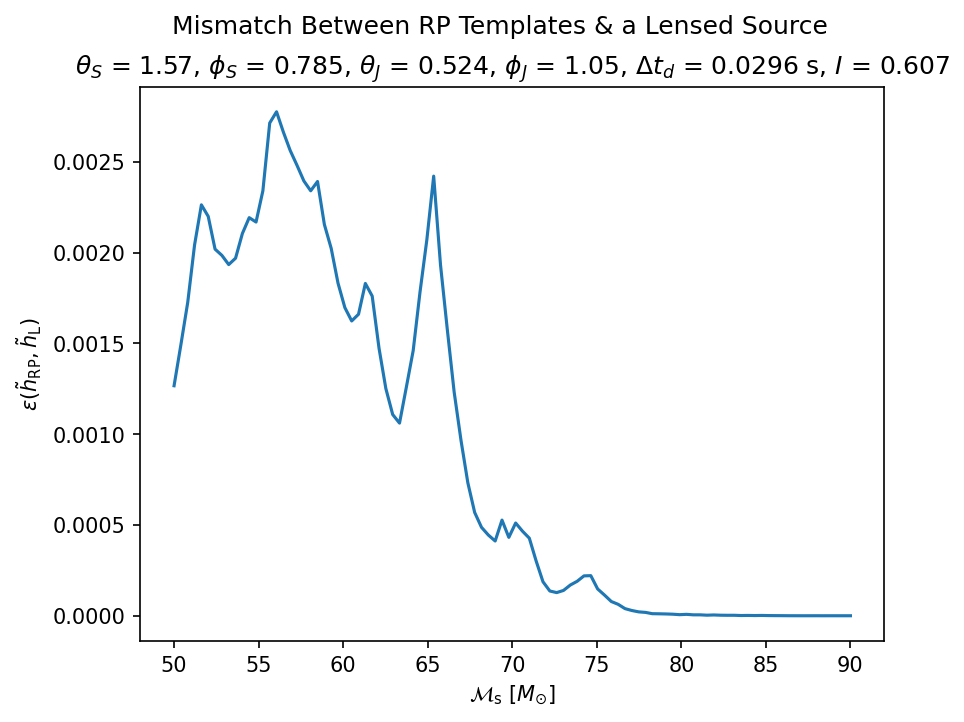

In [24]:
ep_min_arr = np.array([mismatch_mcz_dict[mcz]["ep_min"] for mcz in mcz_L_arr])
plt.plot(mcz_L_arr, ep_min_arr, label=r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")
plt.legend()
plt.xlabel(r"$\mathcal{M}_{\text{s}}$ $[M_{\odot}]$")
plt.ylabel(r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")

# get lensing parameters
lens_inst = LensingGeo(lens_params)
Delta_td = lens_inst.Delta_td()
I = lens_inst.I()

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, $\Delta t_d$ = {:.3g} s, $I$ = {:.3g}".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        Delta_td,
        I,
    )
)

plt.suptitle(
    r"Mismatch Between RP Templates & a Lensed Source"
)

plt.show()

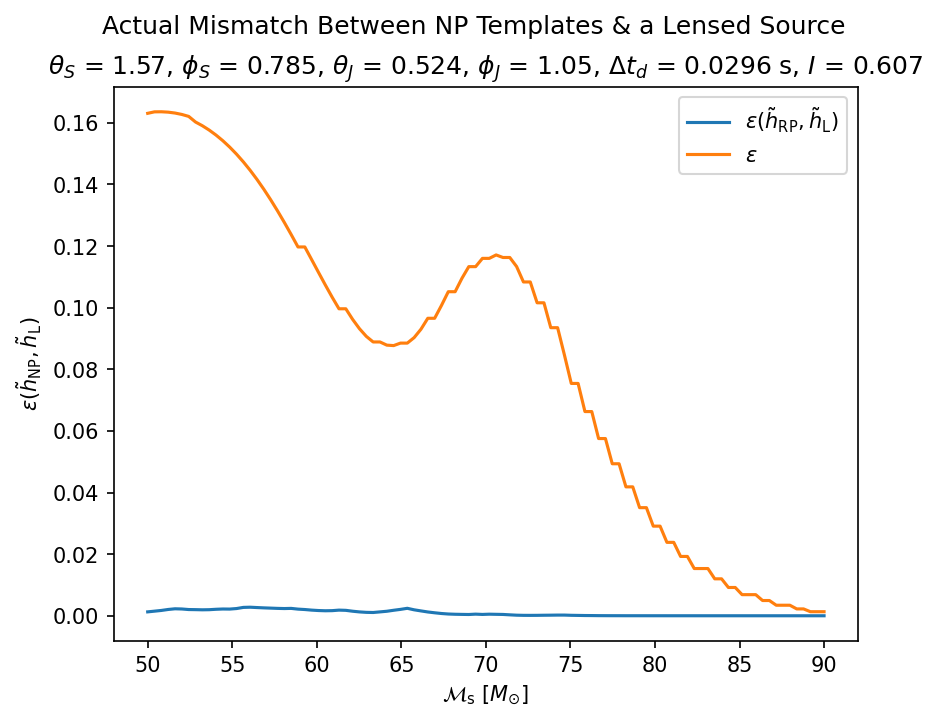

In [32]:
mcz_L_arr = np.linspace(50, 90, 100)

ep_min_arr = np.array([mismatch_mcz_dict[mcz]["ep_min"] for mcz in mcz_L_arr])
plt.plot(mcz_L_arr, ep_min_arr, label=r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")
plt.legend()
plt.xlabel(r"$\mathcal{M}_{\text{s}}$ $[M_{\odot}]$")
plt.ylabel(r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")

# get lensing parameters
lens_inst = LensingGeo(lens_params)
Delta_td = lens_inst.Delta_td()
I = lens_inst.I()

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, $\Delta t_d$ = {:.3g} s, $I$ = {:.3g}".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        Delta_td,
        I,
    )
)

plt.suptitle(
    r"Mismatch Between RP Templates & a Lensed Source"
)

################################################################################

lens_params, RP_params, NP_params = set_to_params(lens_params_1, RP_params_1, NP_params_1)

MLz_range = np.array([3e3])
mismatch_plots_dict = {}

for MLz in MLz_range:
    lens_params["MLz"] = MLz * solar_mass
    mismatch_plots_dict[MLz] = mismatch_plot_general_zoomed(opt_match=True)
    plt.show()